In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Tensor


%matplotlib inline

In [2]:
# read all words
words = open("./makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w +".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [8]:
# SUMMARY -----

In [10]:
# Let's train a deeper network
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: Tensor) -> Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list:
        return [self.weight] + ([] if self.bias is None else [self.bias])
# ----------------------------------------------------------------------------------------------------
class BatchNorm1D:

    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.runnind_var = torch.ones(dim)

    def __call__(self, x: Tensor) -> Tensor:
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)            # batch mean
            xvar = x.var(0, keepdims=True)              # batch variance
        else:
            xmean = self.running_mean
            xvar = self.runnind_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.runnind_var = (1 - self.momentum) * self.runnind_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ----------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x: Tensor) -> Tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self) -> list:
        return []
    

n_embd = 10     # the dimensionality of the character embedding vector
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1 # because the last layer is BatchNorm now
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total amount of trainable parameters
for p in parameters:
    p.requires_grad = True

47551


At this point it is very important to mention that the factor, which the `self.weight` is multiplied is CRUCIAL. The goal is to find a value such that consecutive layers remain distributed equally upon initialization (e.g. each layer has standard normal distribution). Otherwise, the activations/gradients become increasingly bigger/smaller, the deeper you go into the neural network!

In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if not i % 10000: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER DEBUG: take out the 'break' to run full optimization

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

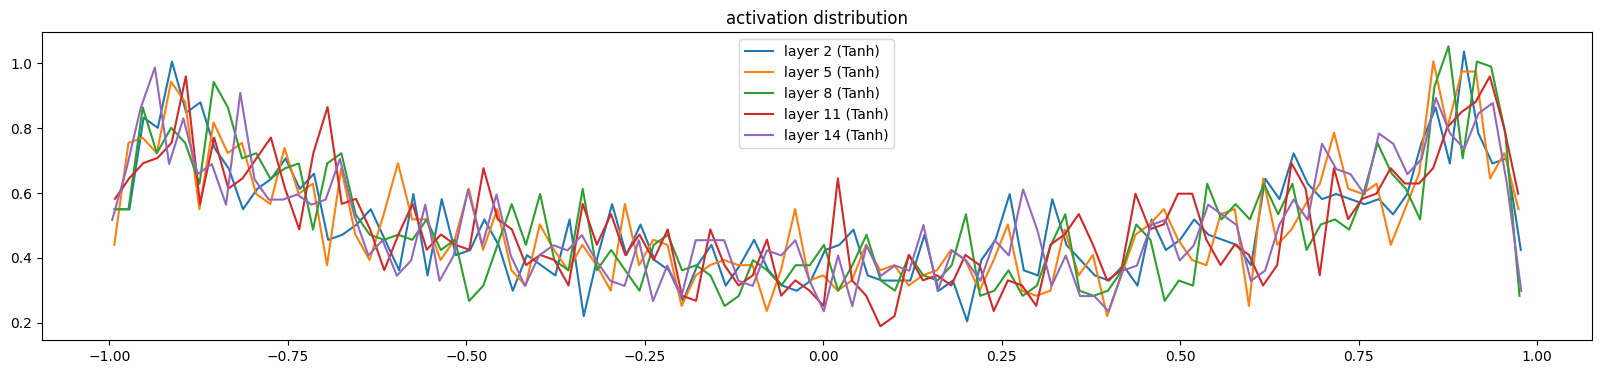

In [12]:
# visualize histrograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # NOTE: exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 3.860916e-03
layer 5 (      Tanh): mean +0.000000, std 3.310031e-03
layer 8 (      Tanh): mean +0.000000, std 3.105929e-03
layer 11 (      Tanh): mean -0.000000, std 2.750410e-03
layer 14 (      Tanh): mean -0.000000, std 2.485619e-03


Text(0.5, 1.0, 'gradient distribution')

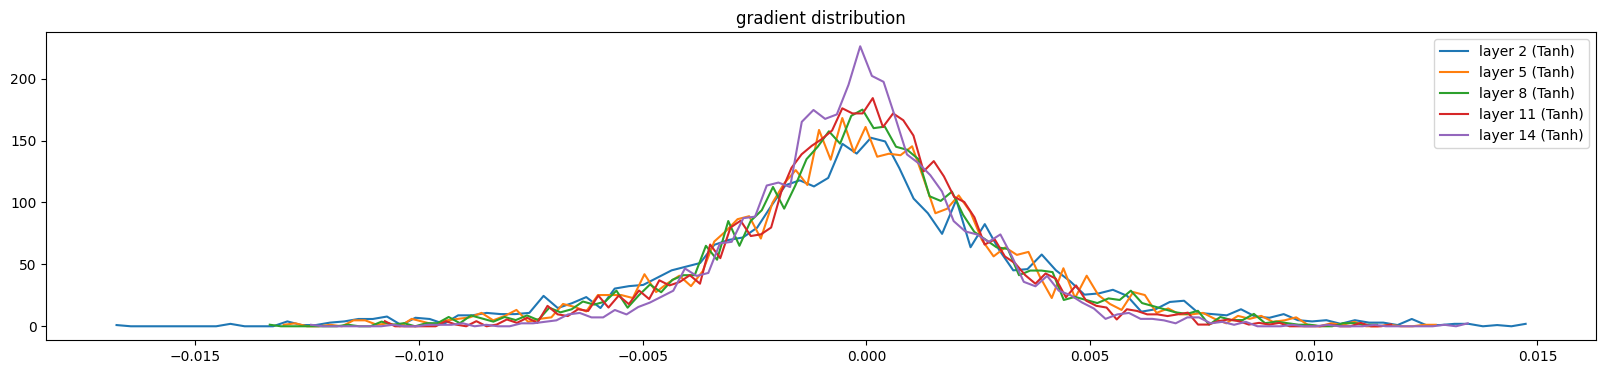

In [13]:
# visualize histrograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # NOTE: exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 9.878526e-03 | grad:data ratio 9.868572e-03
weight  (30, 100) | mean -0.000094 | std 8.747964e-03 | grad:data ratio 2.799228e-02
weight (100, 100) | mean +0.000160 | std 7.655440e-03 | grad:data ratio 4.581042e-02
weight (100, 100) | mean +0.000066 | std 6.817395e-03 | grad:data ratio 4.043709e-02
weight (100, 100) | mean +0.000010 | std 6.177768e-03 | grad:data ratio 3.681591e-02
weight (100, 100) | mean +0.000014 | std 5.331897e-03 | grad:data ratio 3.176153e-02
weight  (100, 27) | mean -0.000046 | std 9.655391e-03 | grad:data ratio 5.796680e-02


Text(0.5, 1.0, 'weights gradient distribution')

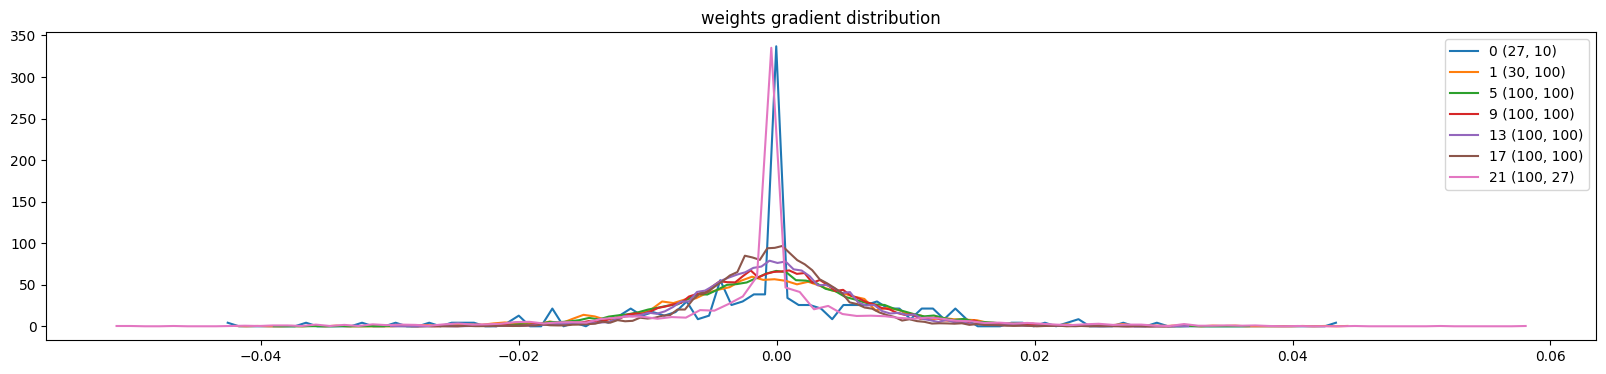

In [14]:
# visualize histrograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2:        
        print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

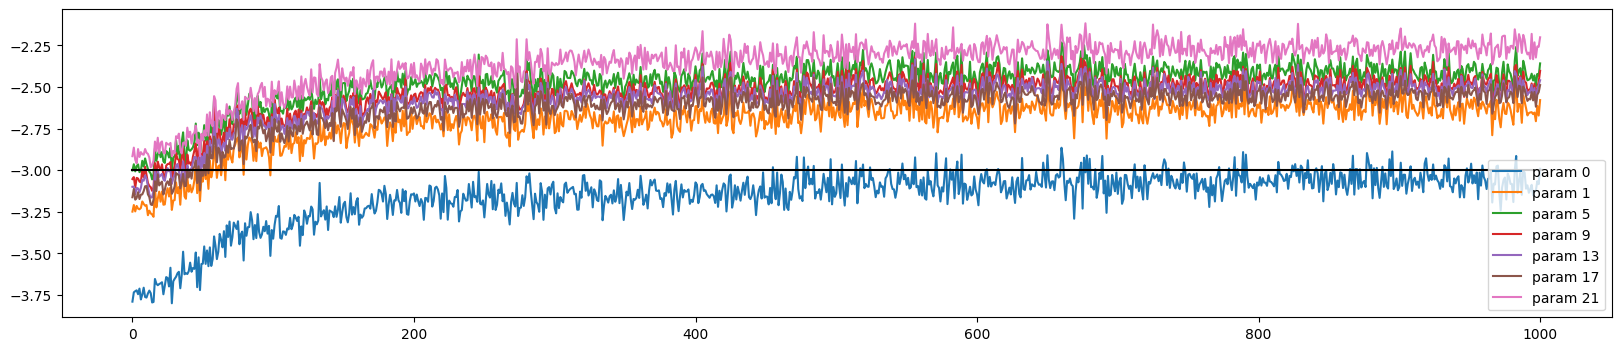

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim ==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k") # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize as "..."
    while True:
        
        # forward pass the neural network
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        x = emb.view(1, -1) # concatenate the vectors

        for layer in layers:
            x = layer(x)
            
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special "." token, break

        if not ix:
            break
    
    print("".join(itos[i] for i in out)) # decode and print the generated word